### 0.0 Libraries

In [76]:
import math
import datetime
import inflection
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt

from scipy                 import stats
from dython.nominal        import associations
from tabulate              import tabulate
from matplotlib.gridspec   import GridSpec
from IPython.display       import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

#### 1.1 Helper Functions

In [77]:
# Ajuste de tamanho para os gráficos criados
sns.set(rc={'figure.figsize':(12, 10)})

# Atalho para o uso das funções das bibliotecas de ajuste estatístico
rs = RobustScaler()
mms = MinMaxScaler()
le = LabelEncoder()


# Cramer's V -> fórmula para se medir a correlação de variáveis categóricas simetricamente
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# Theil's U -> fórmula para se medir a correlação de variáveis categóricas simetricamente
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

#### 1.2 Loading Data

In [78]:
df_sales_raw = pd.read_csv('csv_files/train.csv', low_memory=False)
df_store_raw = pd.read_csv('csv_files/store.csv', low_memory=False)

# Merging
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

### 1.0 Data Description

#### 2.1 Rename Columns

In [79]:
df1 = df_raw.copy()

In [80]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

#### 2.2 Data Dimensions

In [81]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

#### 2.3 Data Types

In [82]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

#### 2.4 Check NA

In [83]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

#### 2.5 Fill NA

In [84]:
#competition_distance -> filling the dataset with a high distance value
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [85]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

#### 2.6 Change Types

In [86]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [87]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

#### 2.7 Descriptive Statistical

In [88]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [89]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 2.7.1 Numerical Attributes

In [90]:
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
d3 = pd.concat([d1, d2]).T.reset_index()
d3.columns = ['attributes', 'skew', 'kurtosis']
d3

,attributes,skew,kurtosis
0,store,-0.000955,-1.200524
1,day_of_week,0.001593,-1.246873
2,sales,0.641460,1.778375
3,customers,1.598650,7.091773
4,open,-1.758045,1.090723
5,promo,0.487838,-1.762018
6,school_holiday,1.677842,0.815154
7,competition_distance,10.242344,147.789712
8,competition_open_since_month,-0.042076,-1.232607
9,competition_open_since_year,-7.235657,124.071304


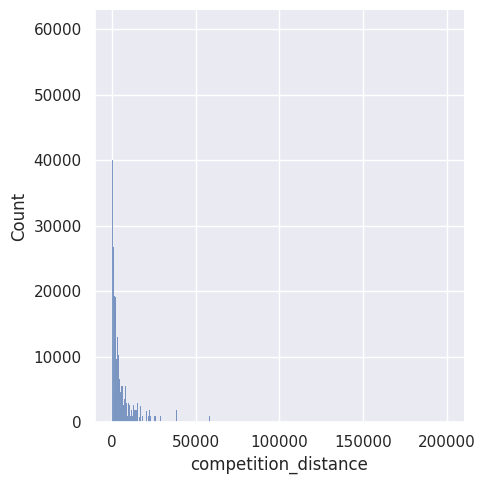

In [91]:
sns.displot(df1['competition_distance'])

#### 2.7.1 Categorical Attributes

<AxesSubplot: xlabel='assortment', ylabel='sales'>

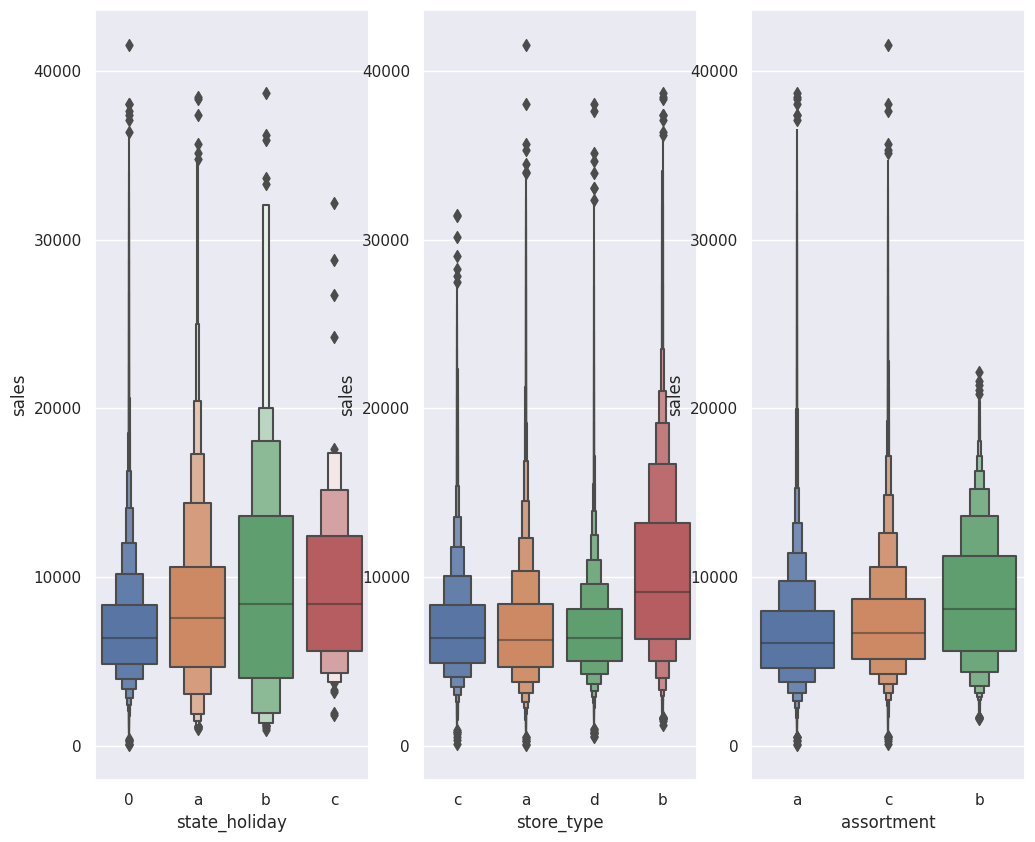

In [92]:
#sns.set(rc={'figure.figsize':(15, 10)})
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0 )]

plt.subplot(1, 3, 1)
sns.boxenplot(x='state_holiday' , y='sales' , data=aux1 )

plt.subplot(1, 3, 2)
sns.boxenplot(x='store_type' , y='sales' , data=aux1 )

plt.subplot(1, 3, 3)
sns.boxenplot(x='assortment' , y='sales' , data=aux1 )

### 2.0 Feature Engineering

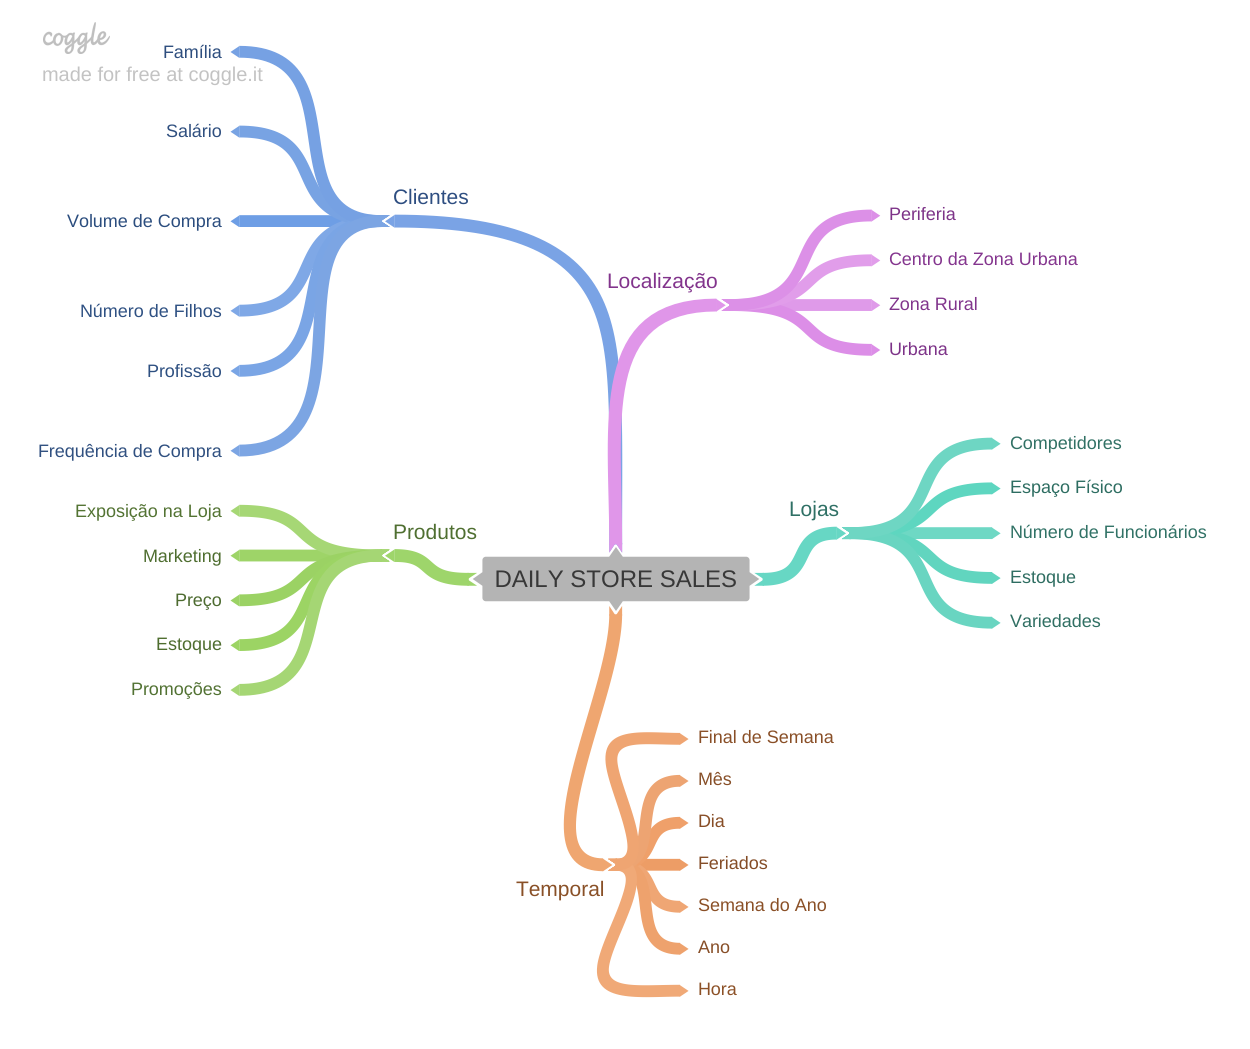

In [93]:
Image('img/mind_map_hypthesis.png')

#### 3.1 Hypothesis

1. Lojas com maior sortimentos vendem mais?
2. Lojas com competidores mais próximos vendem menos?
3. Lojas com competidores há mais tempo vendem mais?
4. Lojas com promoções ativas por mais tempo vendem mais?
5. Lojas com promoções consecutivas vendem mais?
6. Lojas abertas durante o feriado do Natal vendem mais?
7. Lojas mais antigas vendem mais?
8. Lojas vendem mais nos finais de semana?
10. Lojas vendem menos em feriados?

#### 3.1 Feature Engineering

In [94]:
df2 = df1.copy()

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)    
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days= 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [95]:
df2.sample(5).T

,743720,503382,385286,814025,708097
store,801,188,296,861,858
day_of_week,2,7,5,2,6
date,2013-09-03 00:00:00,2014-04-06 00:00:00,2014-07-25 00:00:00,2013-07-02 00:00:00,2013-10-05 00:00:00
sales,3220,0,5933,3740,3776
customers,377,0,716,556,319
open,1,0,1,1,1
promo,0,0,0,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,d,d,a,c,a


### 3.0 Data Filtering

In [96]:
df3 = df2.copy()

#### 4.1 Row Filtering

In [97]:
df3 = df3[(['open'] != 0) & (df3['sales'] > 0)]

#### 4.2 Column Filtering

In [98]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [99]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### 4.0 EDA (Exploration Data Analysis)

In [100]:
df4 = df3.copy()

#### 5.1 Univariate Analysis

5.1.1 Response Variable

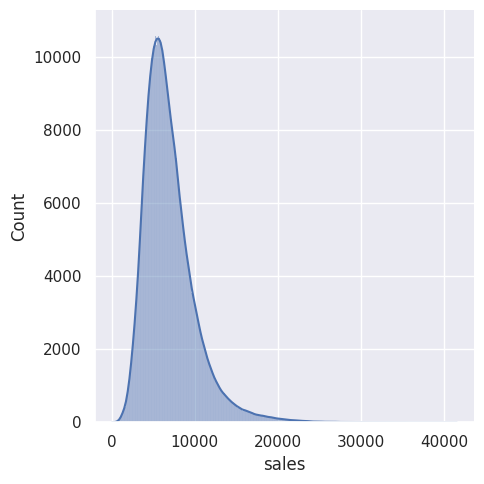

In [101]:
sns.displot(df4['sales'], kde=True)

5.1.2 Numerical Variable

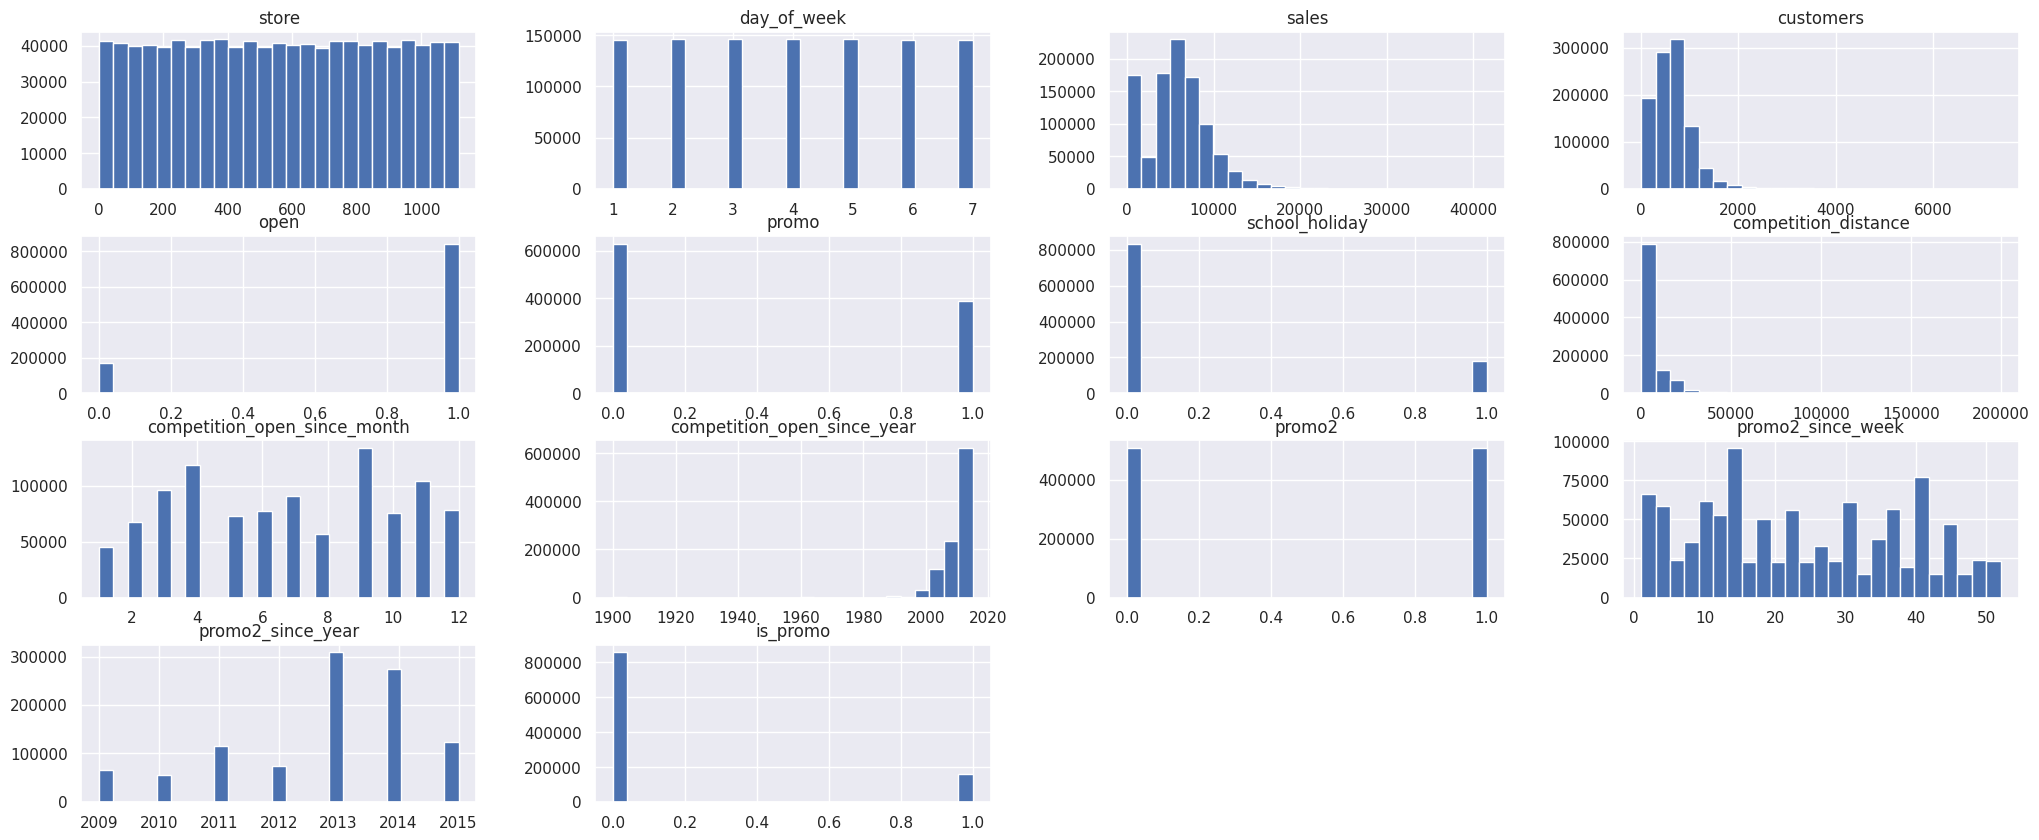

In [102]:
num_attributes.hist(bins=25, figsize=(25, 10));

5.1.2 Categorical Variable

In [103]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

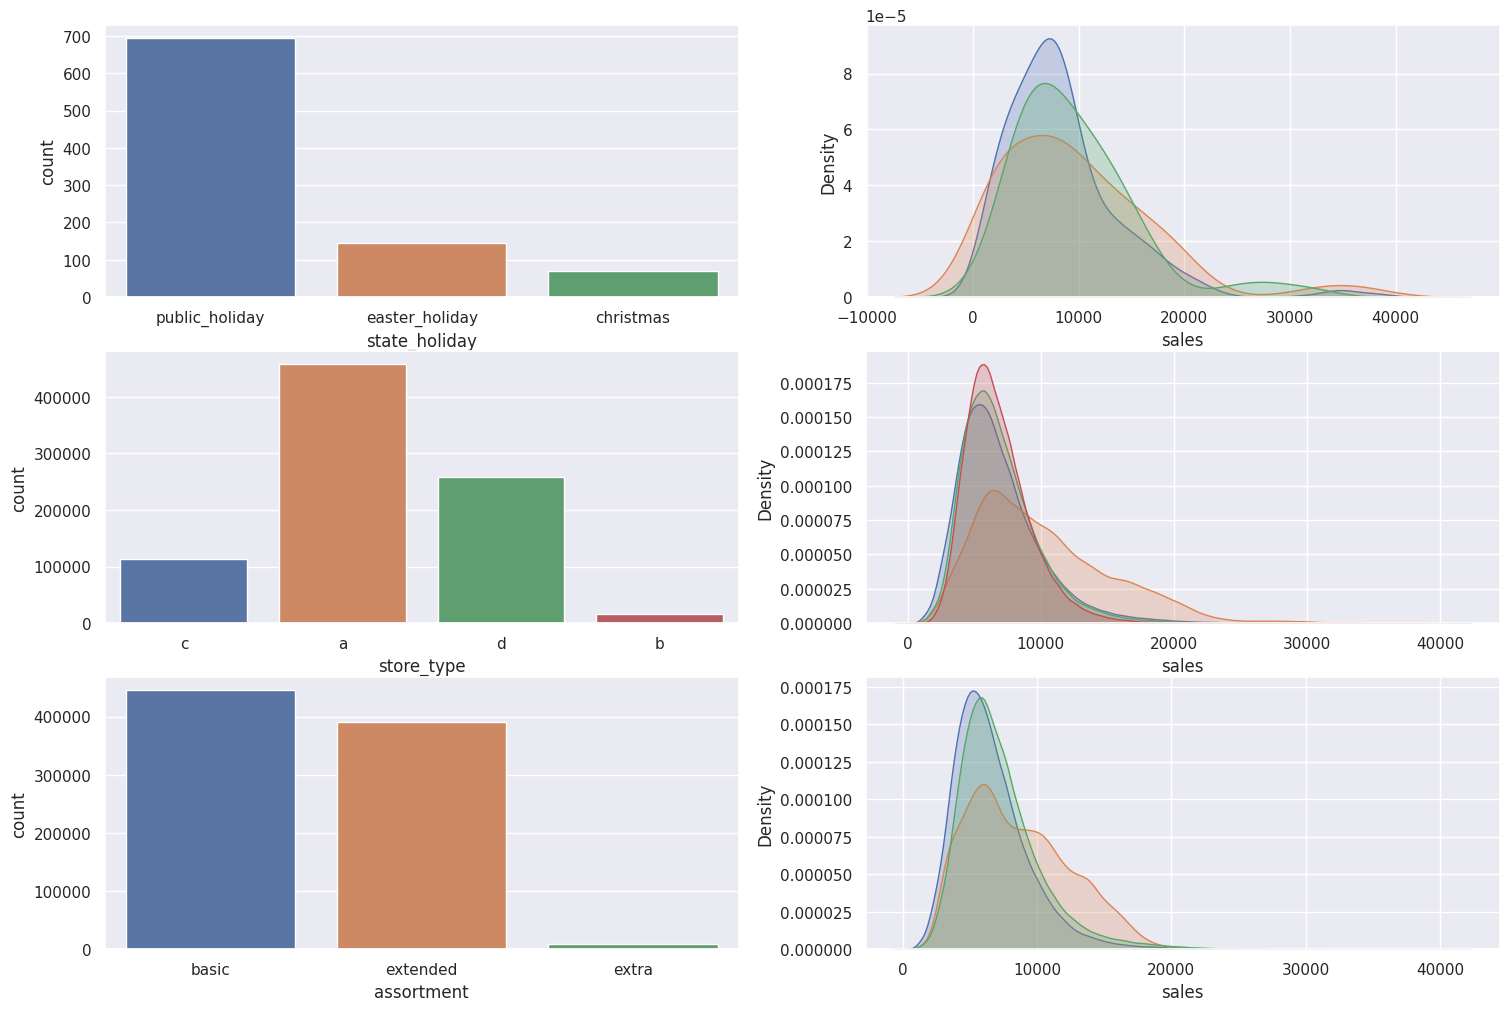

In [104]:
plt.rcParams['figure.figsize']=(18, 12)

# State holiday
plt.subplot(3, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=aux)

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# Store Type
plt.subplot(3, 2, 3)
sns.countplot(data=df4, x= 'store_type')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(data=df4, x= 'assortment')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True);

#### 5.1 Bivariate Analysis

##### 1. Lojas com maior sortimentos vendem mais?

-> A hipótese é FALSA. As lojas que possuem maior sortimento VENDEM MENOS no geral.

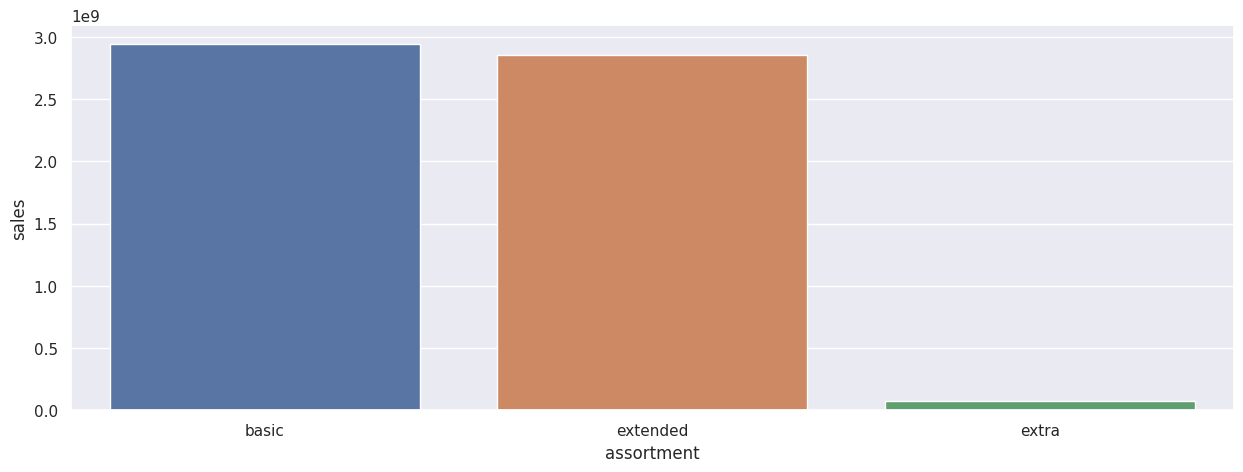

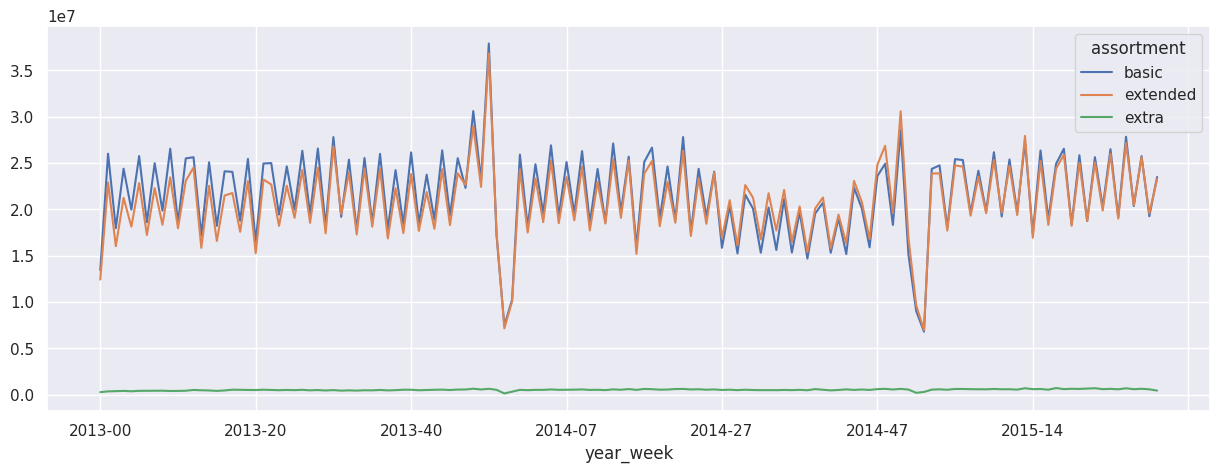

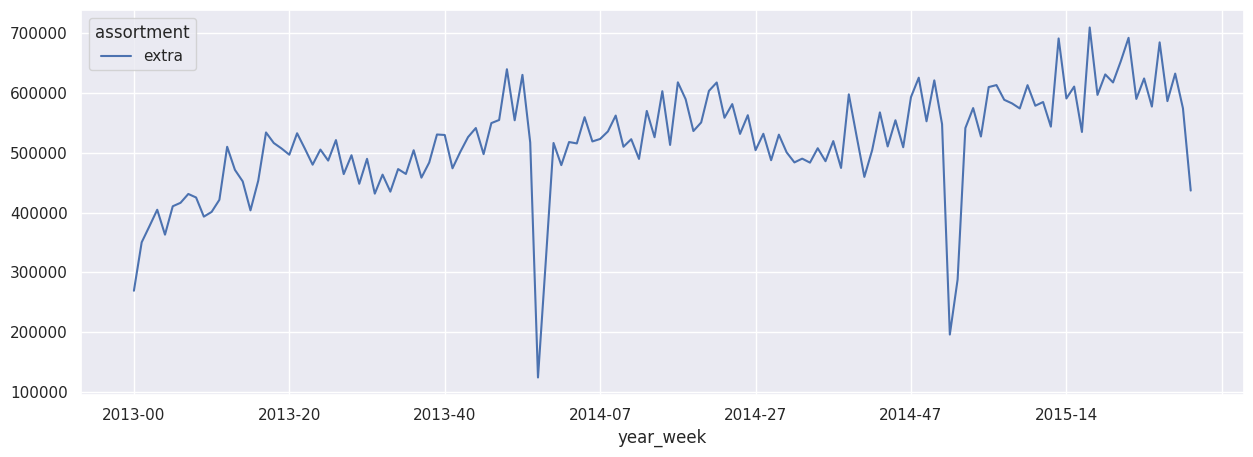

In [105]:
plt.rcParams['figure.figsize']=(15, 5);

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

##### 2. Lojas com competidores mais próximos vendem menos?
-> A hipótese é FALSA. Lojas com COMPETIDORES MAIS PRÓXIMOS VENDEM MAIS.

/tmp/ipykernel_42675/3230588918.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True);


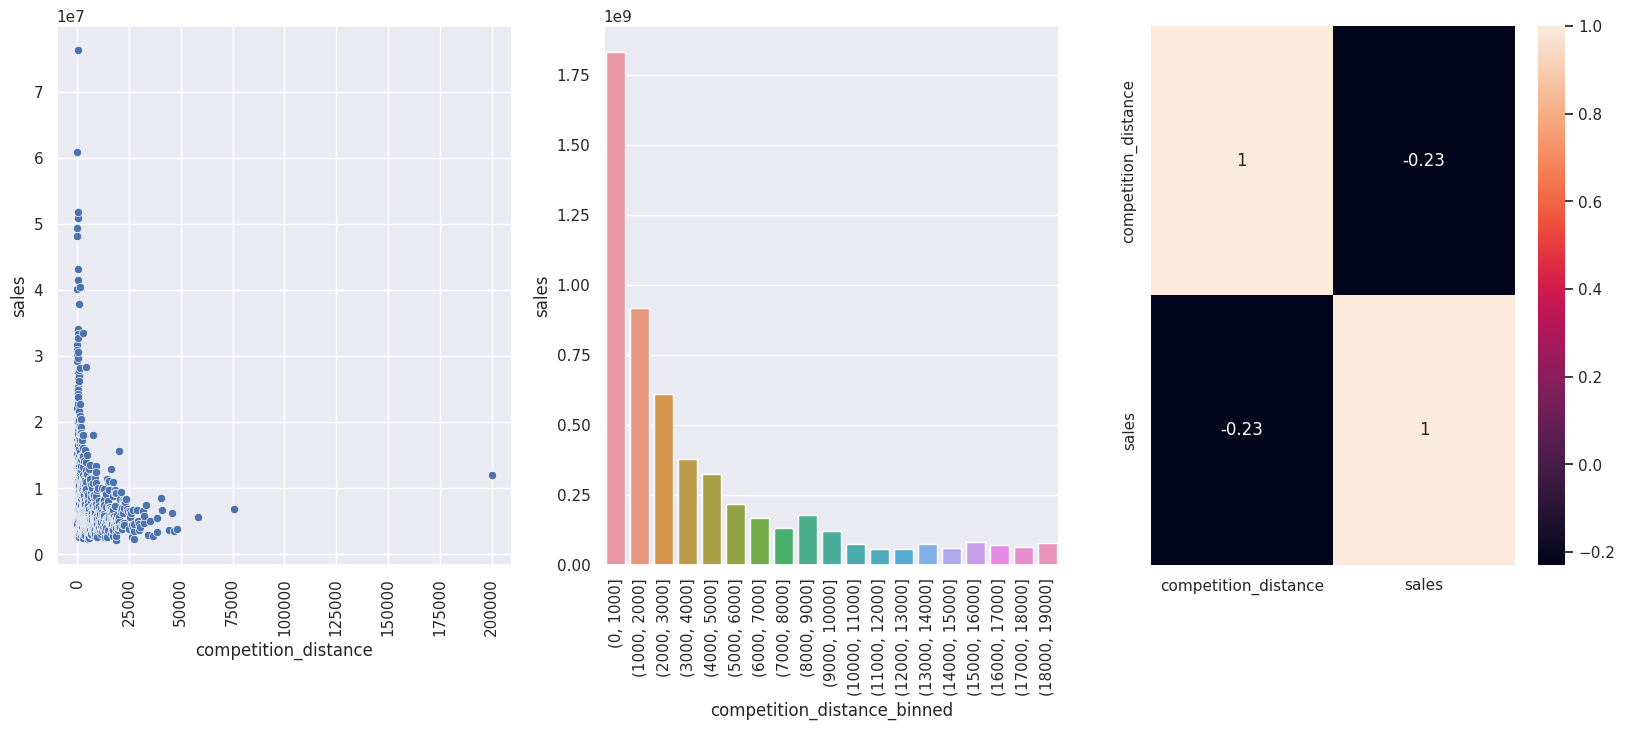

In [106]:
plt.rcParams['figure.figsize']=(20, 7);

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### 3. Lojas com competidores há mais tempo vendem mais?
->  A hipótese é FALSA. Lojas com competidores há mais tempo VENDEM MENOS.

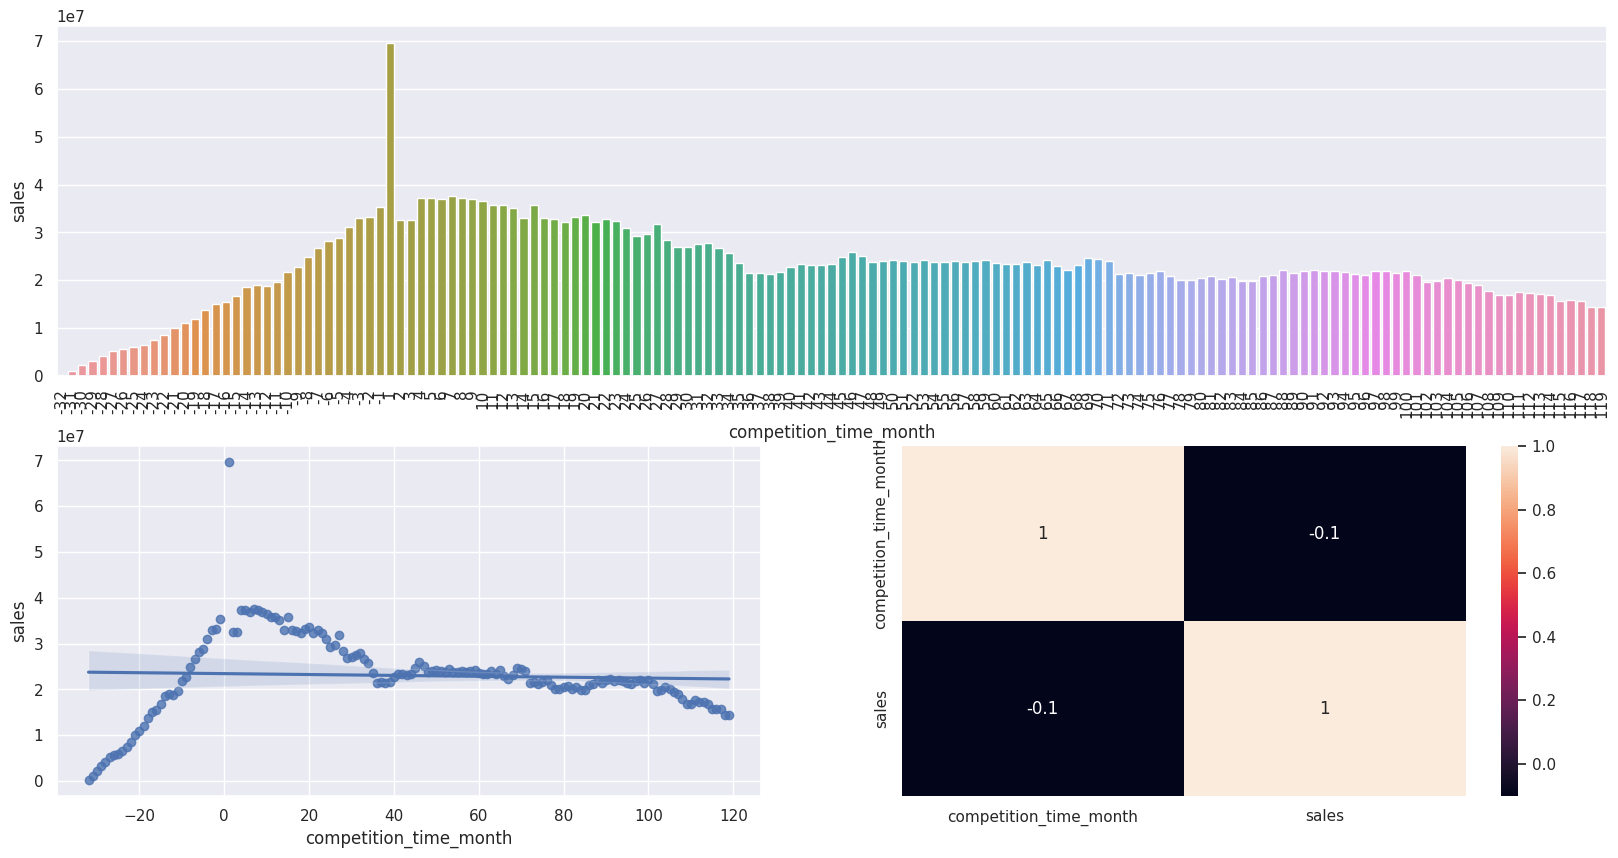

In [107]:
plt.rcParams['figure.figsize']=(20, 10);

# linha, coluna, posição
plt.subplot(2, 1, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(2, 2, 3)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(2, 2, 4)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### 4. Lojas com promoções ativas por mais tempo vendem mais?
-> A hipótese é FALSA. Depois de um certo período de promoção as lojas passam a vender MENOS.

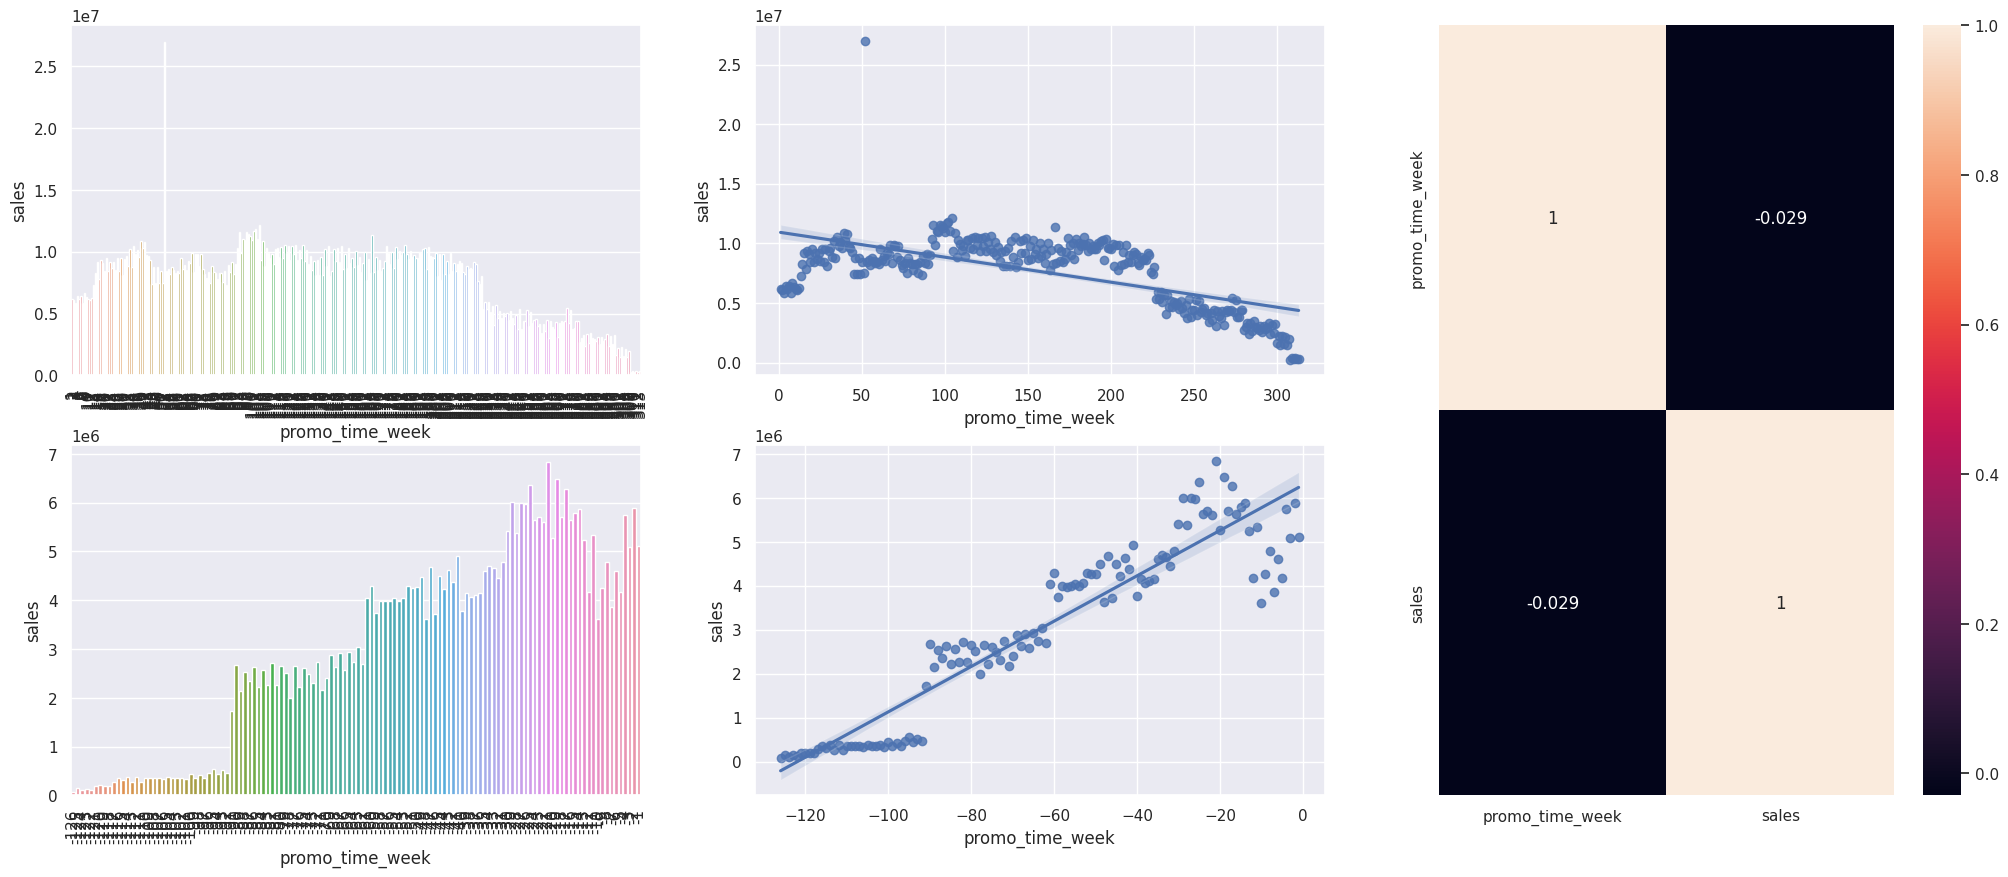

In [108]:
plt.rcParams['figure.figsize']=(25, 10);
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
grid = GridSpec(2,3)

# promo extendido
aux2 = aux1[aux1['promo_time_week'] > 0]
plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);
plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

# promo regular
aux3 = aux1[aux1['promo_time_week'] < 0]
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);
plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

# correlação
plt.subplot(grid[2:])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### 5. Lojas com promoções consecutivas vendem mais?
-> A hipótese é falsa. As lojas com promoções consecutivas vendem MENOS.

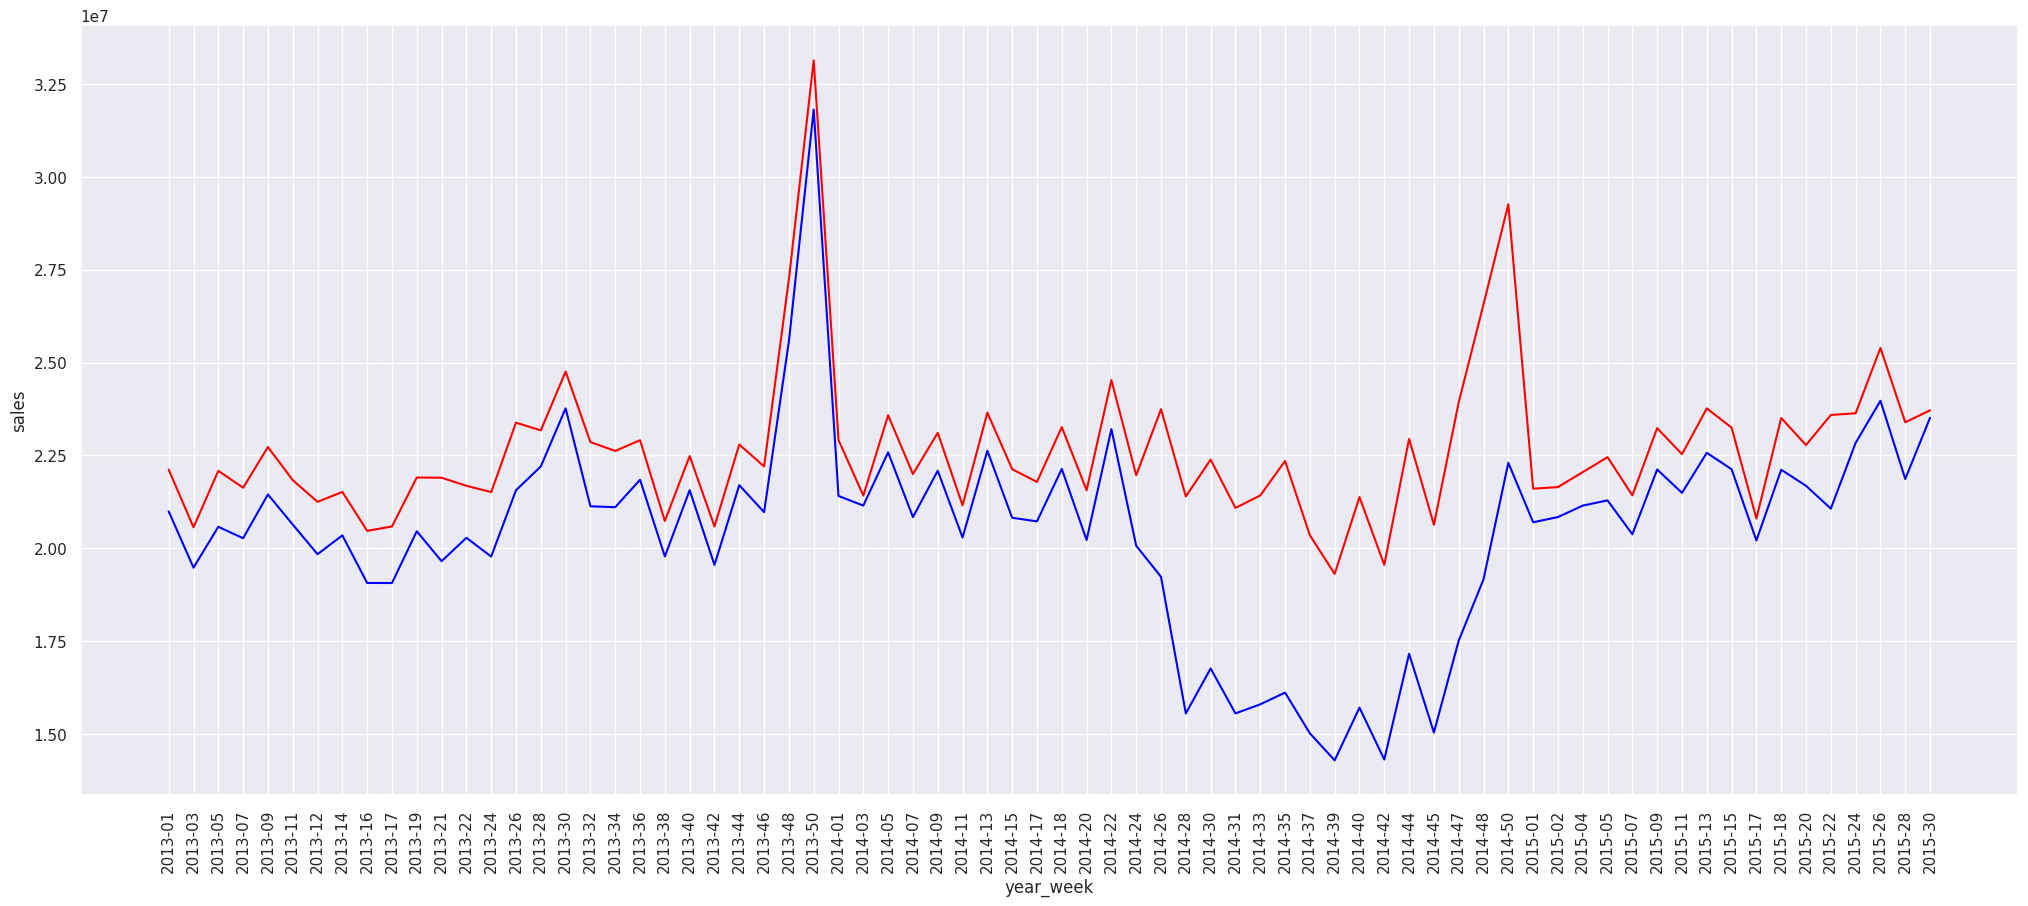

In [109]:
#plt.rcParams['figure.figsize']=(16, 8);
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
#ax = aux1.plot()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
#aux2.plot(ax=ax)
#ax.legend(labels=['Tradicional e Extendida', 'Extendida']);

fig, ax = plt.subplots()
sns.lineplot(x="year_week", y="sales", color='blue', data=aux1, ax=ax);
sns.lineplot(x="year_week", y="sales", color='red', data=aux2, ax=ax);
plt.xticks(rotation=90);

##### 6. Lojas abertas durante o feriado do Natal vendem mais?
-> A hipótese é falsa. As lojas abertas durante o feriado do Natal vendem MENOS.

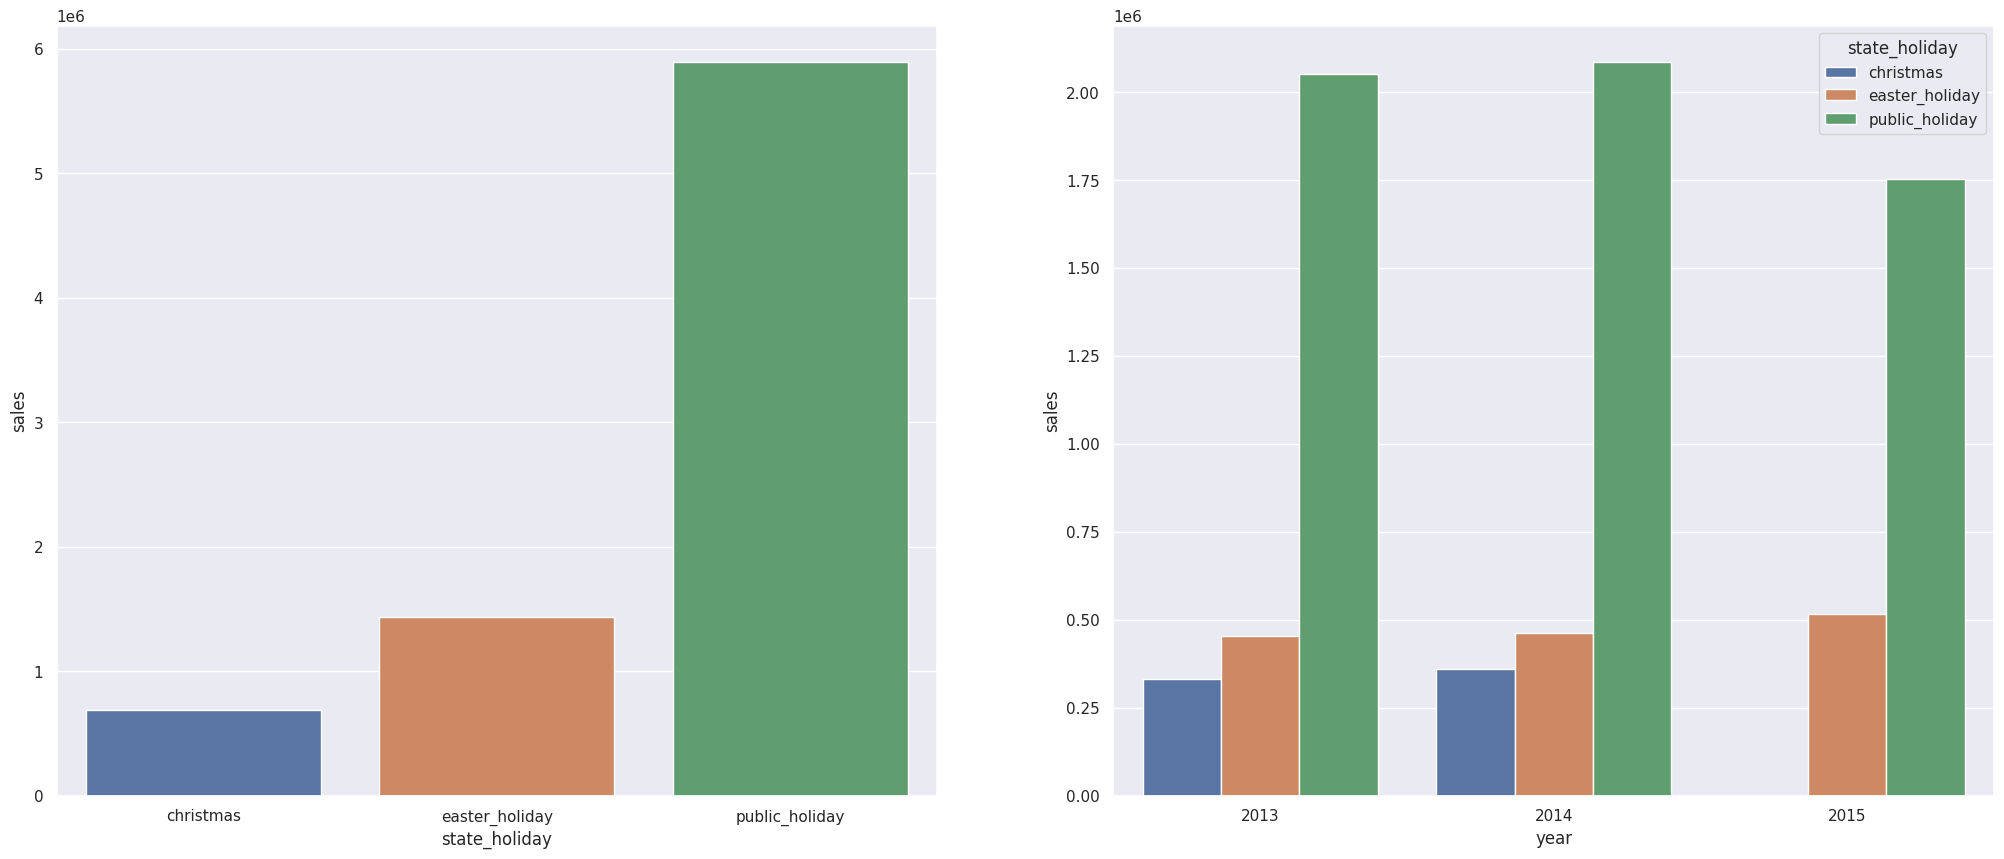

In [110]:
plt.subplot(1, 2, 1)
aux1 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index() 
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'year', 'sales']].groupby(['state_holiday', 'year']).sum().reset_index() 
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

##### 7. As lojas estão vendendo mais ao longo dos anos?
-> A hipótese é falsa. As vendas estão diminuindo ao longo dos anos.

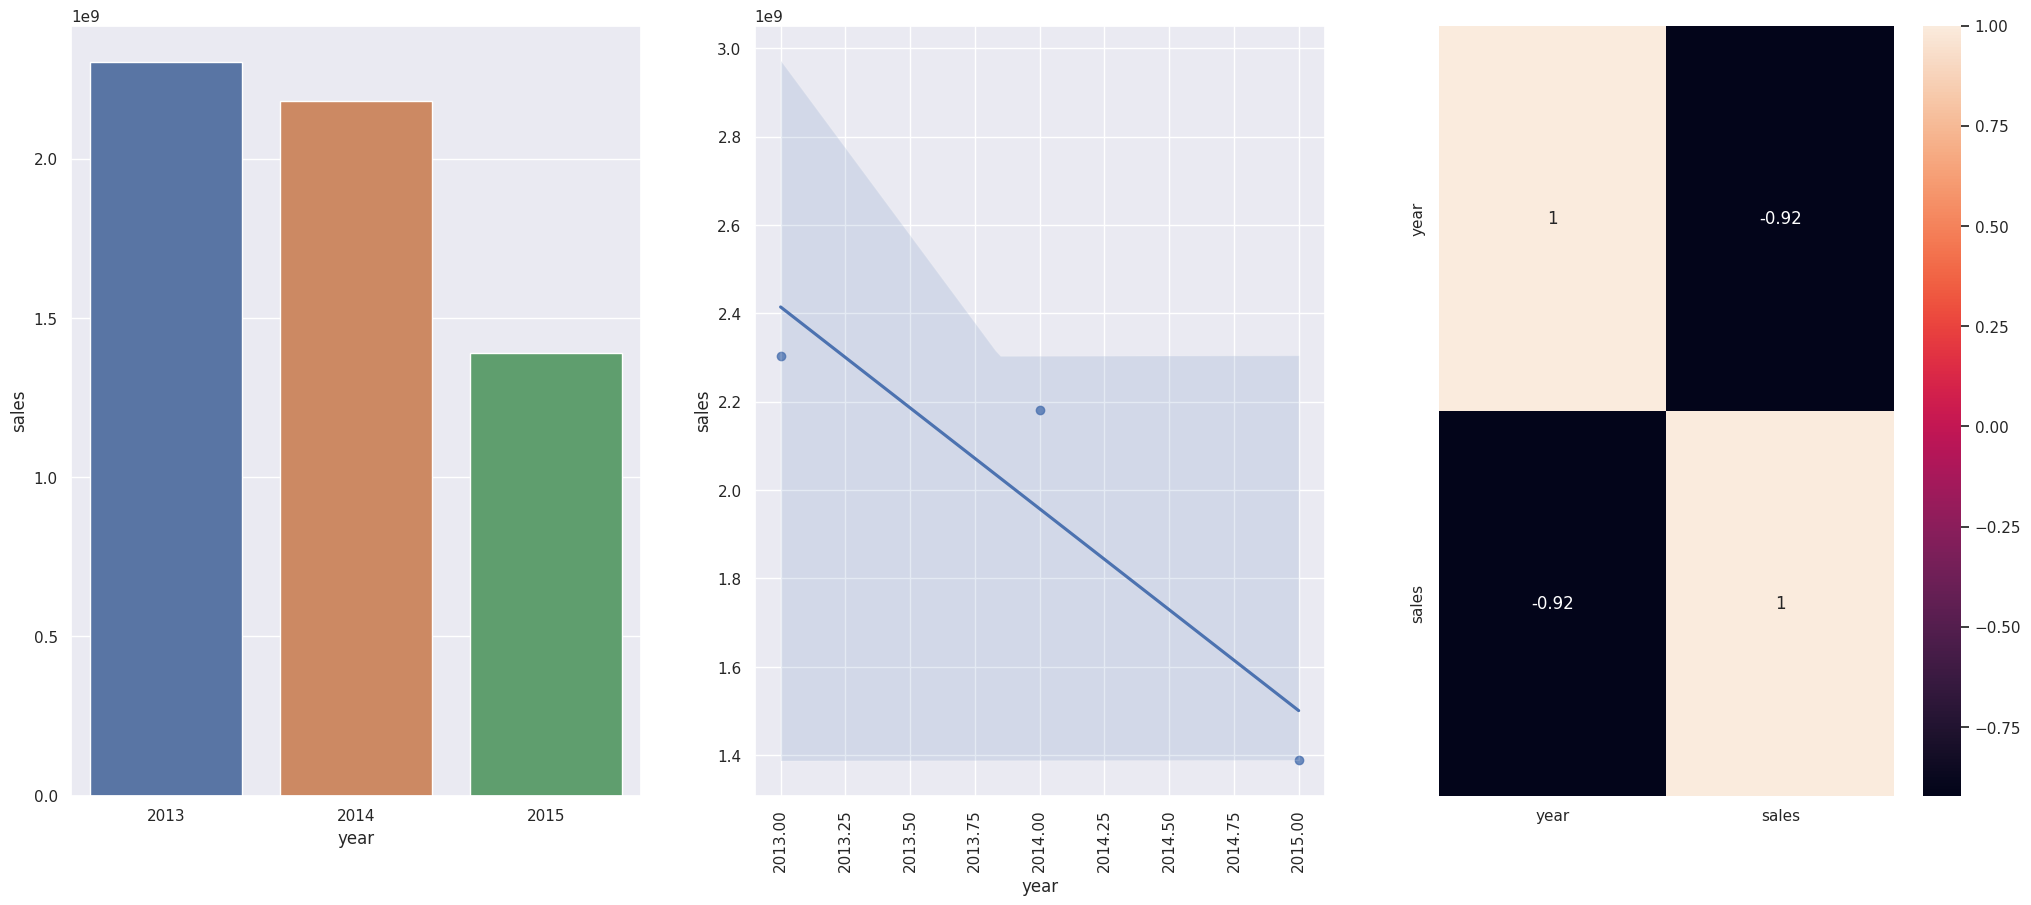

In [111]:
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.regplot(x='year', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### 8. Lojas vendem menos nos finais de semana?
-> A hipótese é verdadeira. As lojas vendem MENOS nos finais de semana.

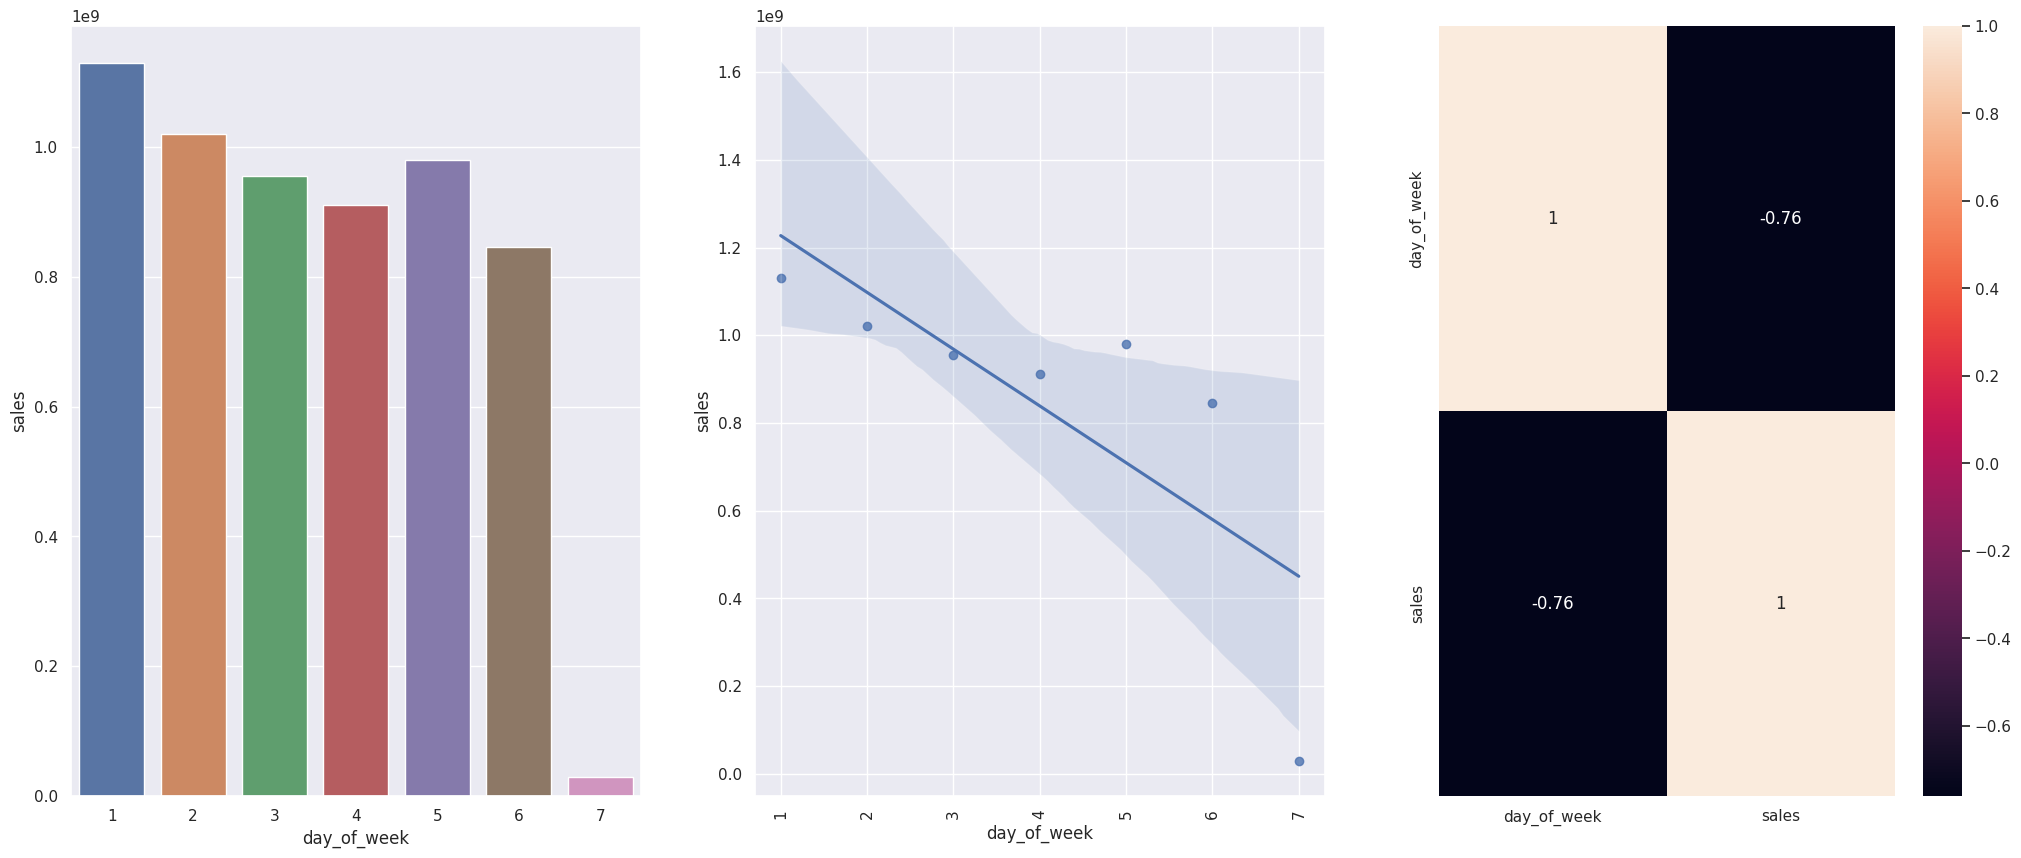

In [112]:
grid = GridSpec(1,3)

plt.subplot(grid[0,0])
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(grid[0,1])
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.regplot(x='day_of_week', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(grid[0,2])
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### 10. Lojas vendem mais depois do 10º dia do mês?
->

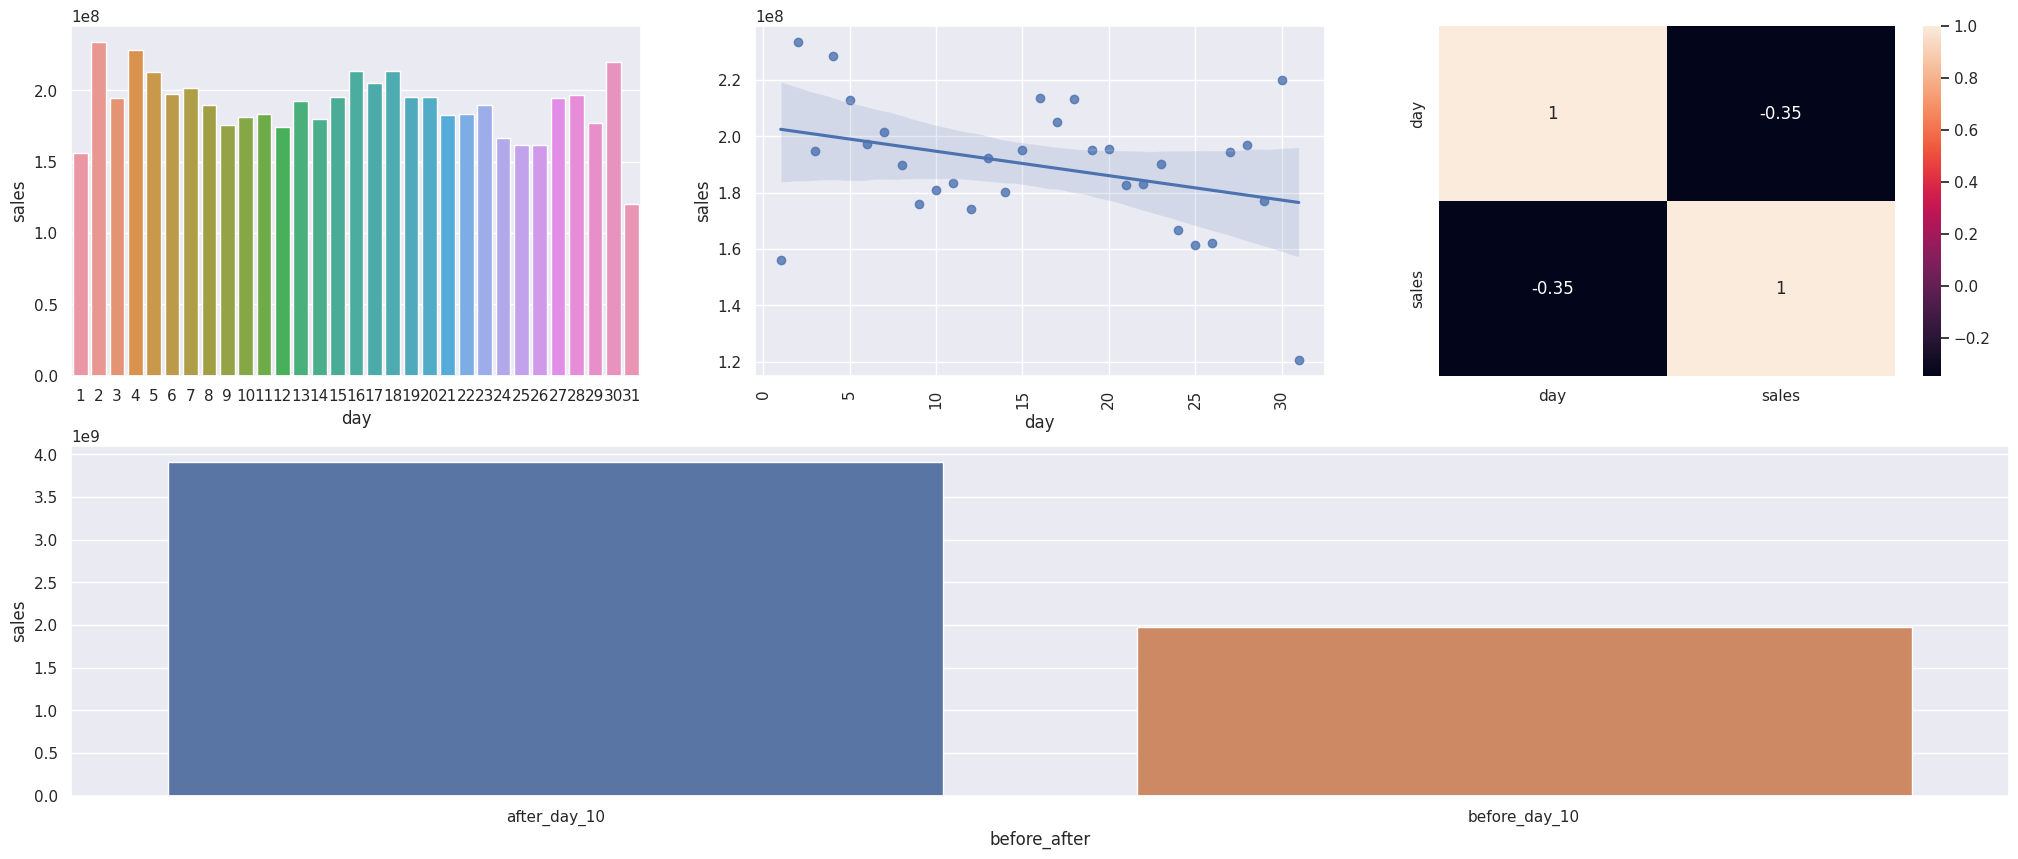

In [113]:
grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(grid[0,1])
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.regplot(x='day', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(grid[0,2])
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(grid[1,:])
sns.barplot(x='before_after', y='sales', data=aux2);

##### Resumo da checagem de Hipóteses

In [114]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


#### 5.1 Multivariate Analysis

##### 5.1.1 Numerical Attributes

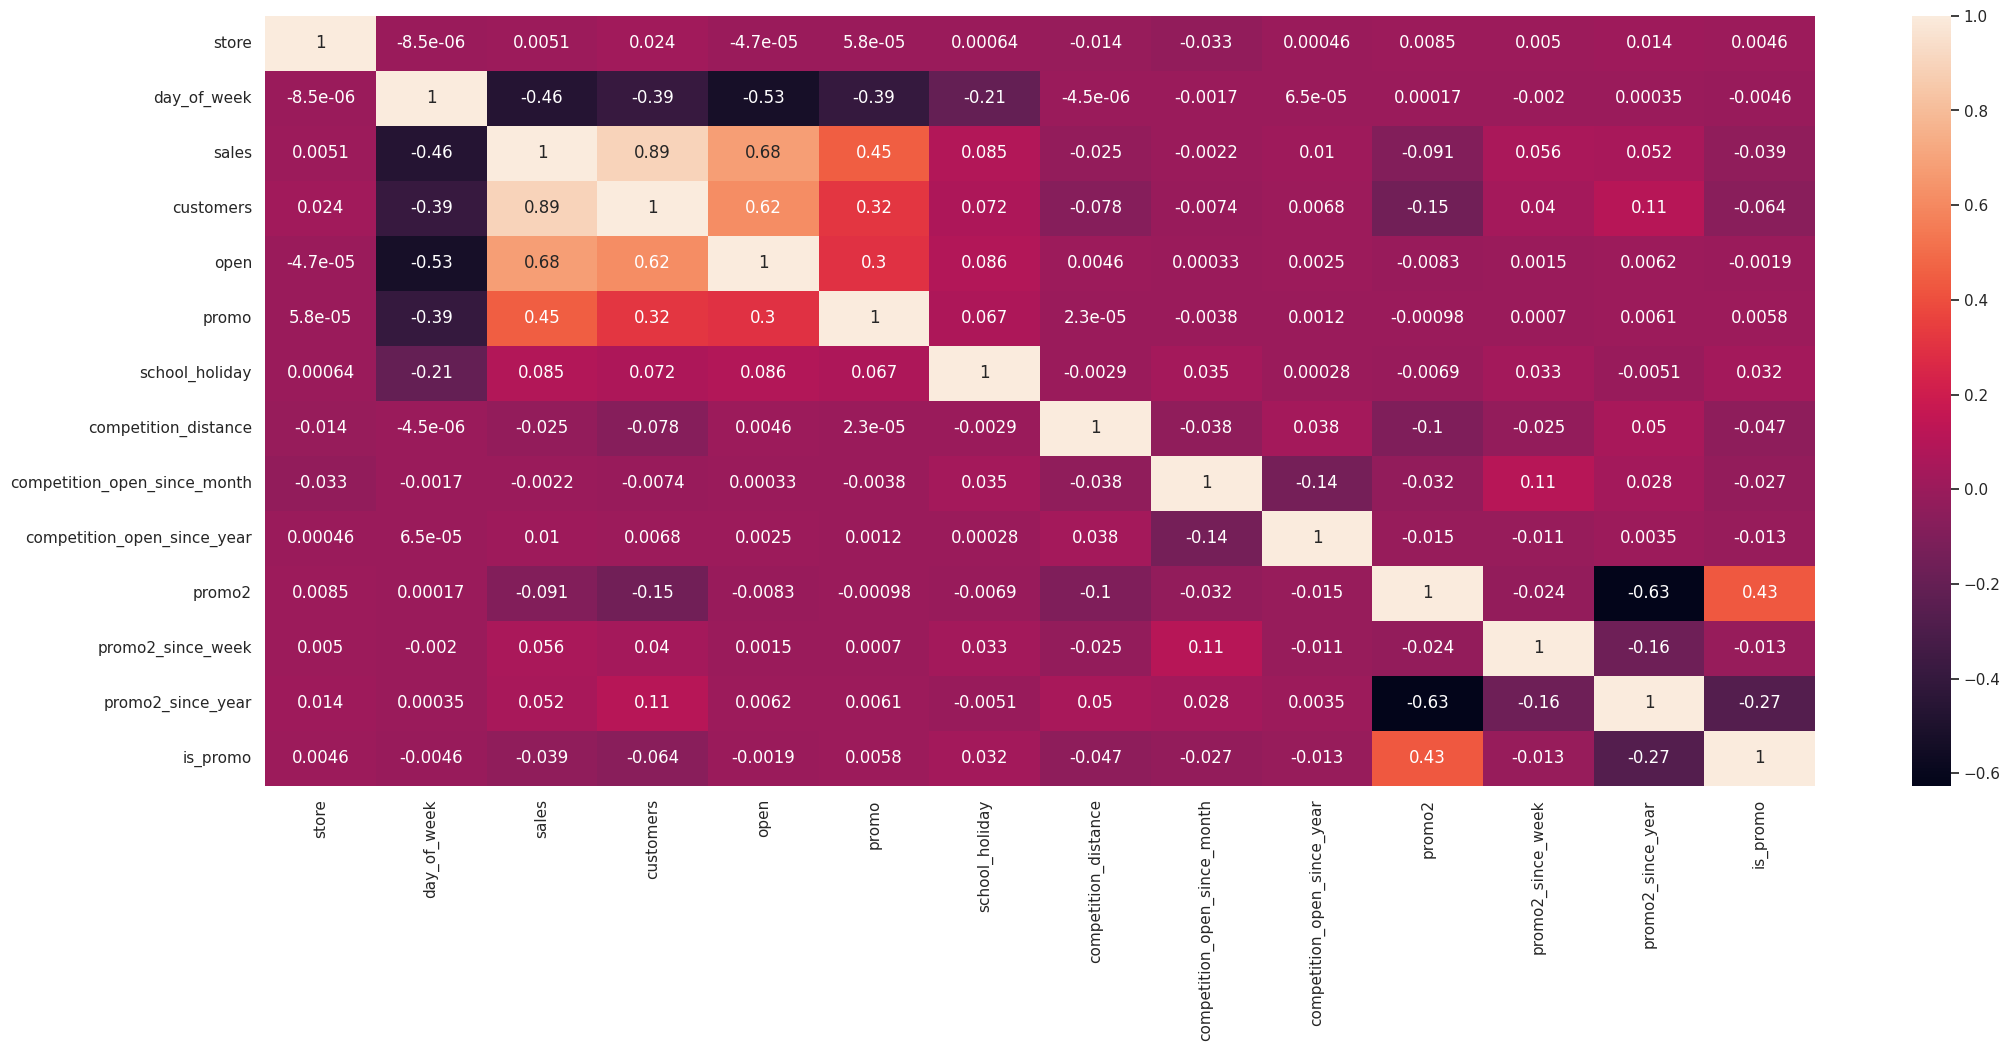

In [115]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

##### 5.1.1 Categorical Attributes

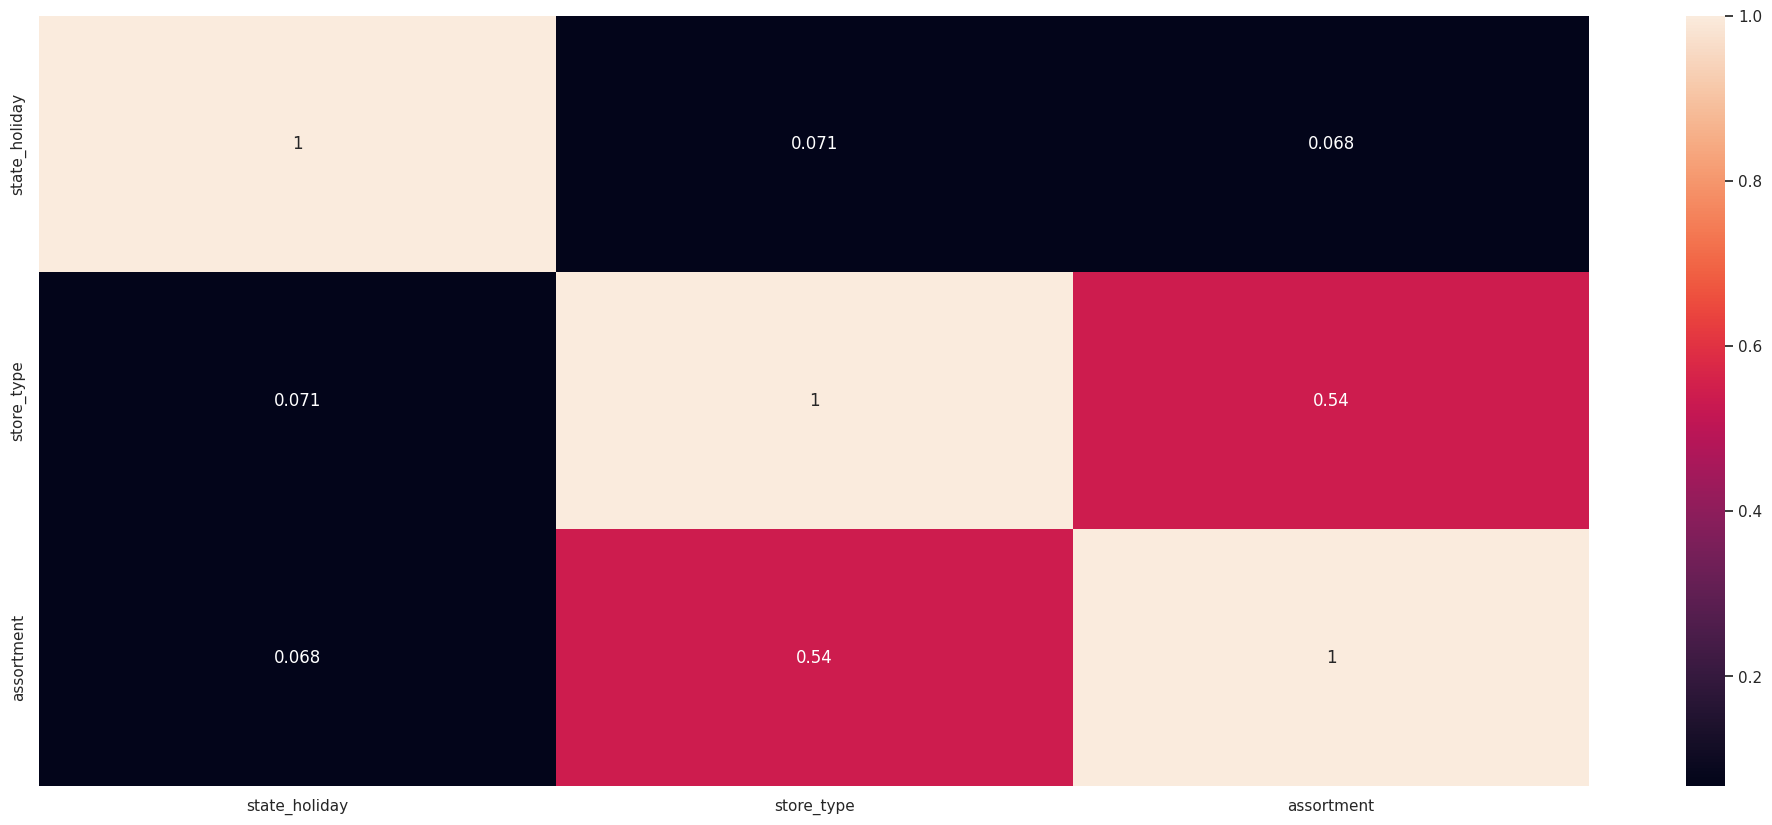

In [116]:
# Separação dos valores categóricos
aux = df4.select_dtypes(include='object')

# Aplicação da correlação categórica de Cramer's V
aux1 = cramers_v(aux['state_holiday'], aux['state_holiday'])
aux2 = cramers_v(aux['state_holiday'], aux['store_type'])
aux3 = cramers_v(aux['state_holiday'], aux['assortment'])

aux4 = cramers_v(aux['store_type'], aux['state_holiday'])
aux5 = cramers_v(aux['store_type'], aux['store_type'])
aux6 = cramers_v(aux['store_type'], aux['assortment'])

aux7 = cramers_v(aux['assortment'], aux['state_holiday'])
aux8 = cramers_v(aux['assortment'], aux['store_type'])
aux9 = cramers_v(aux['assortment'], aux['assortment'])

aux10 = pd.DataFrame({'state_holiday': [aux1, aux2, aux3],
                      'store_type': [aux4, aux5, aux6], 
                      'assortment': [aux7, aux8, aux9]})

aux10 = aux10.set_index(aux10.columns)

sns.heatmap(aux10, annot=True);

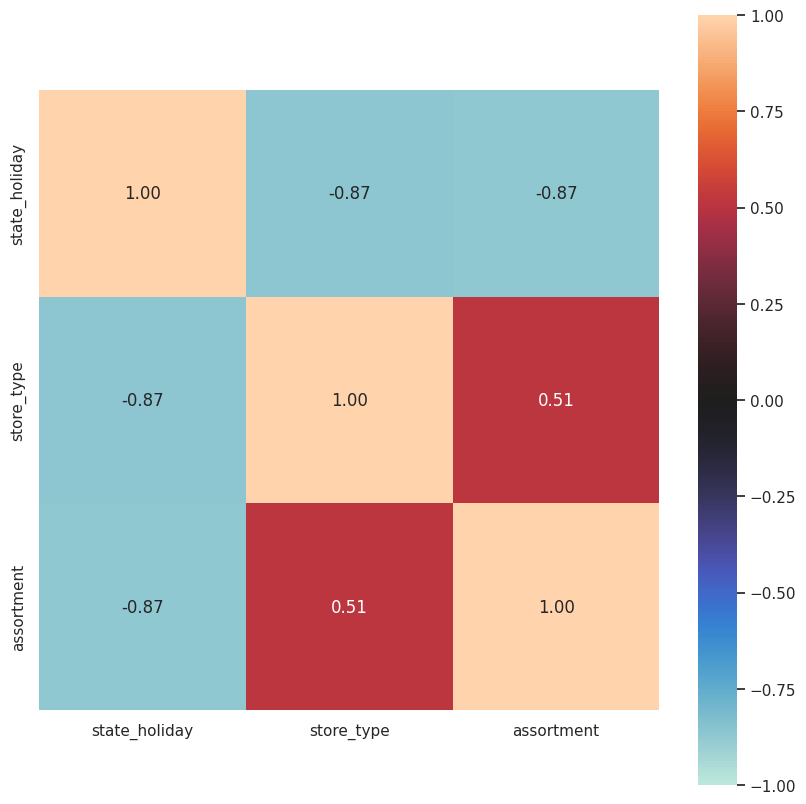

In [117]:
associations(aux10, nom_nom_assoc='theil', figsize=(10,10));

### 5.0 Data Preparation for ML

In [118]:
df5 = df4.copy()

#### 5.1 Normalization

#### 5.2 Rescaling

In [119]:
aux = df5.select_dtypes(include=['int64', 'float64'])

# ajuste da coluna 'competition_distance' -> RobustScaler
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# ajuste da coluna 'competition_time_month' -> RobustScaler
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# ajuste da coluna 'promo_time_week' -> MinMaxScaler
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# ajuste da coluna 'year' -> MinMaxScaler
df5['year'] = mms.fit_transform(df5[['year']].values)


#### 5.3 Transformation

##### 5.3.1 Encoding

In [120]:
# transformação dos conteúdos 'object' para 'int64' -> One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# transformção dos conteúdos 'object' para 'int64' -> Label Encoding
df5['store_type'] = le.fit_transform(df5['store_type'])

# transformação dos conteúdos 'object' para 'int64' -> Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

##### 5.3.1 Response Variable Transformation

In [121]:
df5['sales'] = np.log1p(df5['sales'])

##### 5.3.1 Nature Transformation

In [122]:
# ajuste dos períodos de tempo dos dias do mês, dias da semana, semanas e meses para valores cíclicos utilizando as fórmulas de seno e coseno
# colunas dos dias da semana
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

# dias do mês
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# semanas
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

# meses
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))